In [1]:
# Importing libraries

import h5py

import numpy as np
import matplotlib.pyplot as plt

# Loading Data

In [2]:
# Open h5py file as readable
file = h5py.File('data/train_images.h5', 'r')

In [3]:
# Listing the keys in order to extract the training images
list(file.keys())

['train_images']

In [4]:
# Checking format to ensure that we have 50k images 128x128
file['train_images']

<HDF5 dataset "train_images": shape (50000, 128, 128, 1), type "|u1">

In [5]:
# Store images in a dataset with each image as a NumPy array
x_train = file['train_images']
dataset = x_train[:]

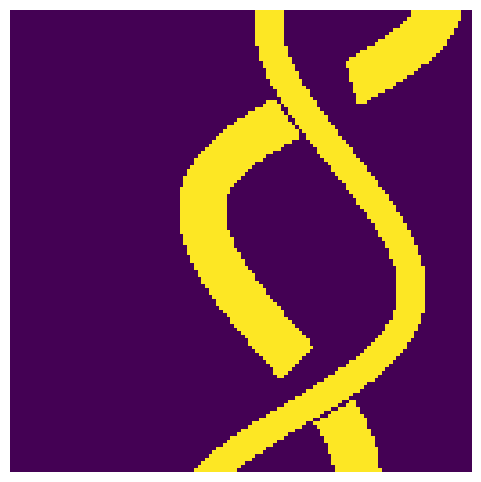

In [6]:
# Plotting images from dataset
plt.figure(figsize=(6,6))

plt.imshow(dataset[15])
plt.axis('off')

plt.show()

# VAE Models


In [7]:
from tensorflow import keras
from tensorflow.keras import layers, models
import tensorflow as tf

In [8]:
# Sample vectors from the latenst space
class Sampling(layers.Layer):
    """"Uses (z_mean, z_log_var) to sample z, the vector enconding an image."""
    def call(self, inputs):
        z_mean, z_log_var = inputs
        batch = tf.shape(z_mean)[0]
        dim = tf.shape(z_mean)[1]
        epsilon = tf.keras.backend.random_normal(shape=(batch,dim))
        return z_mean + tf.exp(0.5 * z_log_var) * epsilon # Reparametrization trick

## Convolutional + Dense VAE

### Network design

In [45]:
# Define the encoder network
latent_dim = 100

encoder_inputs = tf.keras.Input(shape=(128, 128, 1))
x = layers.Conv2D(32, 3, strides=2, activation="relu", padding="same")(encoder_inputs)
x = layers.Conv2D(64, 3, strides=2, activation="relu", padding="same")(x)
x = layers.Flatten()(x)
x = layers.Dense(64, activation="relu")(x)
z_mean = layers.Dense(latent_dim, name="z_mean")(x)
z_log_var = layers.Dense(latent_dim, name="z_log_var")(x)
z = Sampling()([z_mean, z_log_var])

In [46]:
# Define the decoder network
decoder_inputs = layers.Input(shape=(latent_dim,))
x = layers.Dense(32 * 32 * 64, activation="relu")(decoder_inputs)
x = layers.Reshape((32, 32, 64))(x)
x = layers.Conv2DTranspose(64, 3, strides=2, activation="relu", padding="same")(x)
x = layers.Conv2DTranspose(32, 3, strides=2, activation="relu", padding="same")(x)
decoder_outputs = layers.Conv2DTranspose(1, 3, activation="sigmoid", padding="same")(x)

In [47]:
# Create the encoder model
encoder = keras.Model(encoder_inputs, [z_mean, z_log_var, z], name="encoder")
encoder.summary()

Model: "encoder"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_9 (InputLayer)           [(None, 128, 128, 1  0           []                               
                                )]                                                                
                                                                                                  
 conv2d_8 (Conv2D)              (None, 64, 64, 32)   320         ['input_9[0][0]']                
                                                                                                  
 conv2d_9 (Conv2D)              (None, 32, 32, 64)   18496       ['conv2d_8[0][0]']               
                                                                                                  
 flatten_3 (Flatten)            (None, 65536)        0           ['conv2d_9[0][0]']         

In [48]:
# Create the decoder model
decoder = keras.Model(decoder_inputs, decoder_outputs, name="decoder")

decoder.summary()

Model: "decoder"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_10 (InputLayer)       [(None, 100)]             0         
                                                                 
 dense_13 (Dense)            (None, 65536)             6619136   
                                                                 
 reshape_4 (Reshape)         (None, 32, 32, 64)        0         
                                                                 
 conv2d_transpose_8 (Conv2DT  (None, 64, 64, 64)       36928     
 ranspose)                                                       
                                                                 
 conv2d_transpose_9 (Conv2DT  (None, 128, 128, 32)     18464     
 ranspose)                                                       
                                                                 
 conv2d_transpose_10 (Conv2D  (None, 128, 128, 1)      289 

### Model 

In [49]:
class VAE(keras.Model):
    def __init__(self, encoder, decoder, **kwargs):
        super().__init__(**kwargs)
        self.encoder = encoder
        self.decoder = decoder
        self.total_loss_tracker = keras.metrics.Mean(name="total_loss")
        self.reconstruction_loss_tracker = keras.metrics.Mean(name="reconstruction_loss")
        self.kl_loss_tracker = keras.metrics.Mean(name="kl_loss")
        self.regularization_loss = keras.metrics.Mean(name="regularization_loss")

    @property
    def metrics(self):
        return [self.total_loss_tracker,
                self.reconstruction_loss_tracker,
                self.kl_loss_tracker,
                self.regularization_loss]
    
    def train_step(self, data):
        with tf.GradientTape() as tape:
            z_mean, z_log_var, z = self.encoder(data, training=True)
            reconstruction = self.decoder(z)
            reconstruction_loss = tf.reduce_mean(
                tf.reduce_sum(
                    keras.losses.binary_crossentropy(data, reconstruction), axis=(1,2)
                )
            )
            kl_loss = -0.5 * (1 + z_log_var - tf.square(z_mean) - tf.exp(z_log_var))
            kl_loss = tf.reduce_mean(tf.reduce_sum(kl_loss, axis=1))
            mean_loss = tf.reduce_mean(tf.square(z_mean))
            cov_loss = tf.reduce_mean(tf.exp(z_log_var)- z_log_var - 1)
            regularization_loss = mean_loss + cov_loss
            total_loss = reconstruction_loss + kl_loss + regularization_loss
        grads = tape.gradient(total_loss, self.trainable_weights)
        self.optimizer.apply_gradients(zip(grads, self.trainable_weights))
        self.total_loss_tracker.update_state(total_loss)
        self.reconstruction_loss_tracker.update_state(reconstruction_loss)
        self.kl_loss_tracker.update_state(kl_loss)
        self.regularization_loss.update_state(regularization_loss)
        return {"loss": self.total_loss_tracker.result(),
                "reconstruction_loss": self.reconstruction_loss_tracker.result(),
                "kl_loss": self.kl_loss_tracker.result(),
                "regularization_loss": self.regularization_loss.result()
            }        

In [50]:
# Define the VAE model
vae = VAE(encoder, decoder)

# Compile the VAE model
vae.compile(optimizer=keras.optimizers.Adam())

### Training

In [51]:
# Convert x_train to float32 data type, ensure that the data types of x_train and x_decoded_mean match
x_train = np.expand_dims(x_train, -1).astype("float32") / 255 # Normalization of the pixel values

# Reshape the x_train data to match the input shape (128, 128, 1)
x_train_reshaped = x_train.reshape(-1, 128, 128, 1)

In [196]:
# Train the VAE model
vae.fit(x_train_reshaped, epochs=10, batch_size=32)


Epoch 1/10
1563/1563 [==============================] - 473s 300ms/step - loss: 501.4724 - reconstruction_loss: 167.4030 - kl_loss: 9.5135 - regularization_loss: 0.1903
Epoch 2/10
1563/1563 [==============================] - 460s 294ms/step - loss: 102.5195 - reconstruction_loss: 101.7700 - kl_loss: 0.4166 - regularization_loss: 0.0083
Epoch 3/10
1563/1563 [==============================] - 457s 293ms/step - loss: 101.6707 - reconstruction_loss: 101.1419 - kl_loss: 0.6631 - regularization_loss: 0.0133
Epoch 4/10
1563/1563 [==============================] - 451s 289ms/step - loss: 101.7572 - reconstruction_loss: 101.0710 - kl_loss: 0.6909 - regularization_loss: 0.0138
Epoch 5/10
1563/1563 [==============================] - 454s 291ms/step - loss: 101.7028 - reconstruction_loss: 101.0183 - kl_loss: 0.7178 - regularization_loss: 0.0144
Epoch 6/10
1563/1563 [==============================] - 456s 292ms/step - loss: 101.6192 - reconstruction_loss: 100.6759 - kl_loss: 0.8792 - regularization

### Saving/loading models

When dealing with serializing models in Keras, they can't be serialized and thus saved. Instead we save its weights.

For further details: [François Chollet - Guide to Saving and Serializing Models with Keras in TensorFlow 2.0](https://colab.research.google.com/drive/172D4jishSgE3N7AO6U2OKAA_0wNnrMOq#scrollTo=OOSGiSkHTERy).

In [197]:
# Save the VAE model
vae.save_weights("models/vae_dim100_conv_dense__weights", save_format="tf")

In [75]:
# Uncomment to load a saved VAE model
# new_model = VAE(encoder, decoder)
# new_model.compile(optimizer=keras.optimizers.Adam())

# new_model.fit(x_train_reshaped[:5])
# new_model.load_weights("models/test_saving_vae")

1/1 [==============================] - 1s 1s/step - loss: 11282.7637 - reconstruction_loss: 11282.5391 - kl_loss: 0.1121 - regularization_loss: 0.0022


### Predicting new images

In [198]:
# Generate new images from random latent vectors
num_images = 30  # Number of images to generate
random_latent_vectors = tf.random.normal(shape=(num_images, latent_dim))
generated_images = vae.decoder.predict(random_latent_vectors)

1/1 [==============================] - 0s 364ms/step


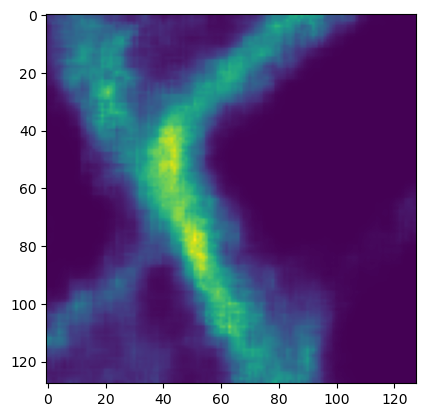

In [199]:
plt.imshow(generated_images[0])

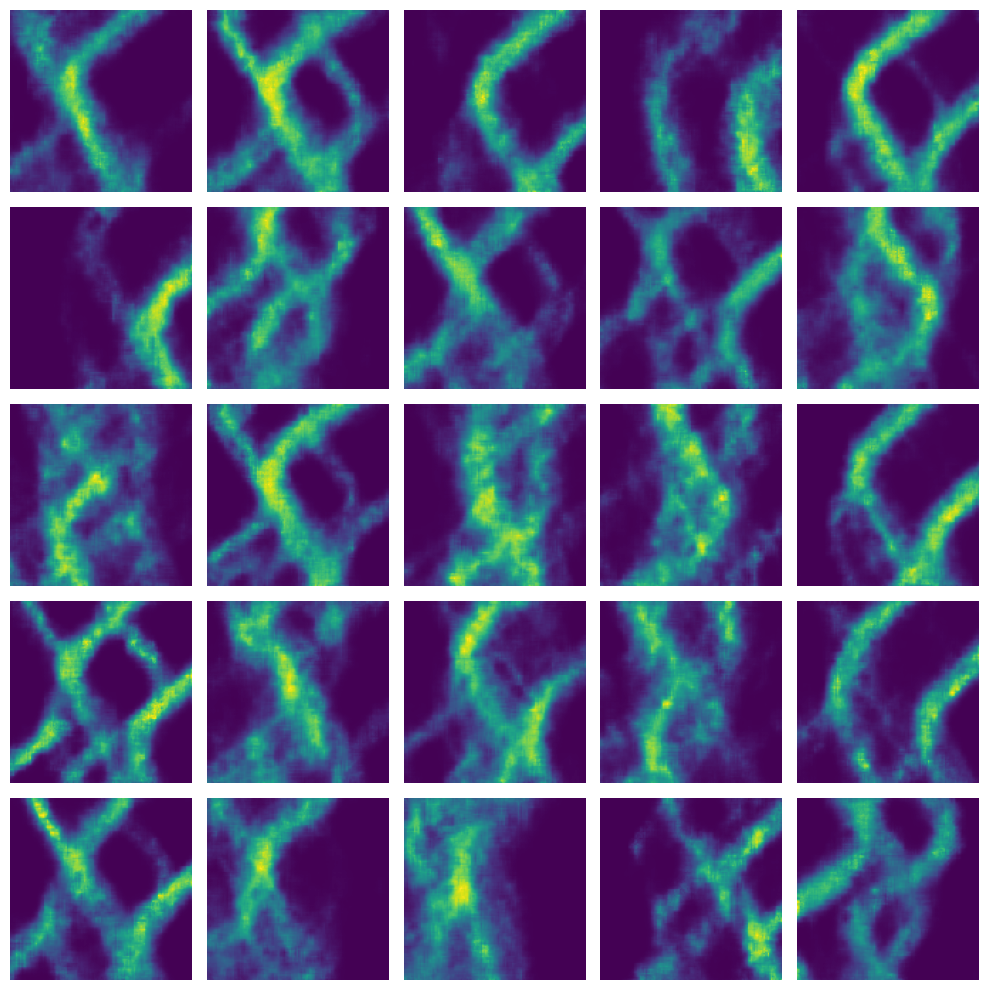

In [218]:
import matplotlib.pyplot as plt

# Reshape the generated images to (num_images, 128, 128)
generated_images = generated_images.reshape((num_images, 128, 128))

# Create a figure and axes
fig, axes = plt.subplots(5, 5, figsize=(10, 10))

# Iterate over the axes and images
for i, ax in enumerate(axes.flat):
    # Plot the image
    ax.imshow(generated_images[i], cmap='viridis')
    ax.axis('off')

# Adjust the spacing between subplots
plt.tight_layout()

# Show the plot
plt.show()

1/1 [==============================] - 0s 26ms/step


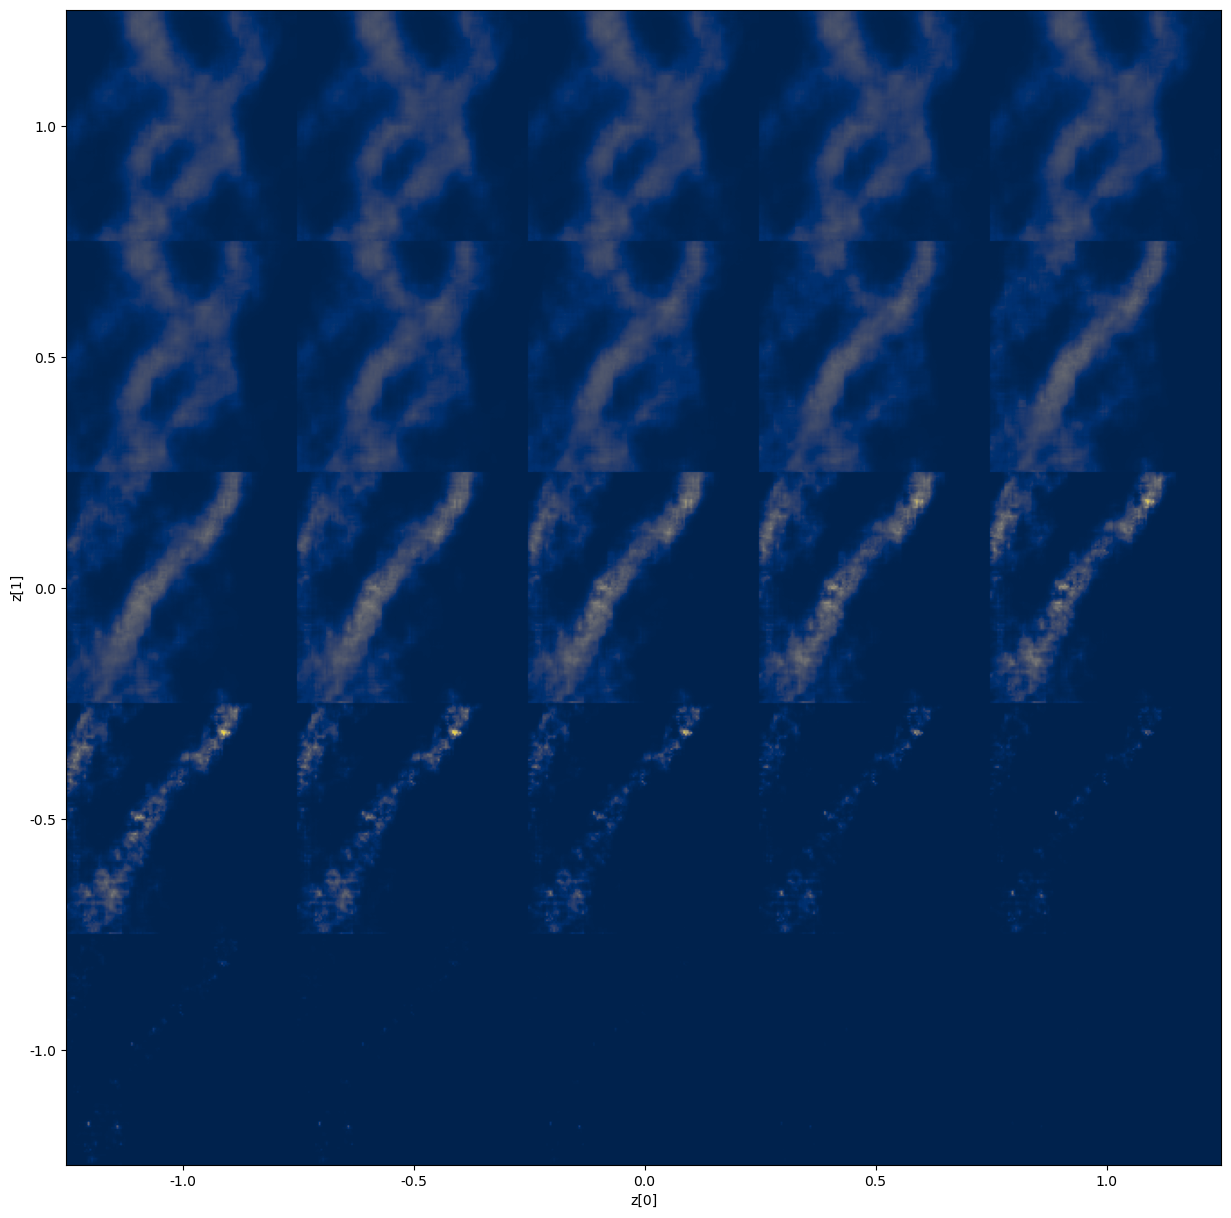

In [217]:
def plot_latent_space(vae, n=5, figsize=15):
    # display a n*n 2D manifold of digits
    digit_size = 128
    scale = 1.0
    figure = np.zeros((digit_size * n, digit_size * n))
    # linearly spaced coordinates corresponding to the 2D plot
    # of digit classes in the latent space
    grid_x = np.linspace(-scale, scale, n)
    grid_y = np.linspace(-scale, scale, n)[::-1]
    # Initial latent vector
    initial_latent_vector = tf.random.normal(shape=(1, latent_dim))

    for i, yi in enumerate(grid_y):
        for j, xi in enumerate(grid_x):
            z_sample = initial_latent_vector + 0.25 * np.mean(initial_latent_vector)
            x_decoded = vae.decoder.predict(z_sample)
            digit = x_decoded[0].reshape(digit_size, digit_size)
            initial_latent_vector = z_sample
            figure[
                i * digit_size : (i + 1) * digit_size,
                j * digit_size : (j + 1) * digit_size,
            ] = digit

    plt.figure(figsize=(figsize, figsize))
    start_range = digit_size // 2
    end_range = n * digit_size + start_range
    pixel_range = np.arange(start_range, end_range, digit_size)
    sample_range_x = np.round(grid_x, 1)
    sample_range_y = np.round(grid_y, 1)
    plt.xticks(pixel_range, sample_range_x)
    plt.yticks(pixel_range, sample_range_y)
    plt.xlabel("z[0]")
    plt.ylabel("z[1]")
    plt.imshow(figure, cmap="cividis")
    plt.show()


plot_latent_space(vae)

This plot shows that little changes in the latent space are implying subtle changes in the output generated image, a property we are looking for, regularization of the latent space.

## Fully Convolutional Variational Autoencoders (FCVAEs)

In [16]:
# Define the encoder network
latent_dim = 100

encoder_inputs = tf.keras.Input(shape=(128, 128, 1))
x = layers.Conv2D(32, 3, strides=2, activation="relu", padding="same")(encoder_inputs)
x = layers.Conv2D(64, 3, strides=2, activation="relu", padding="same")(x)
x = layers.Conv2D(64, 3, strides=1, activation="relu", padding="same")(x)
x = layers.Conv2D(latent_dim, 1, activation="relu")(x)
z_mean = layers.GlobalAveragePooling2D(name="z_mean")(x) # Keep attention: Global average pooling is used to reduce the spatial dimensions of the output.
z_log_var = layers.GlobalAveragePooling2D(name="z_log_var")(x)
z = Sampling()([z_mean, z_log_var])

In [17]:

# Define the decoder network
decoder_inputs = layers.Input(shape=(latent_dim,))
x = layers.Reshape((1, 1, latent_dim))(decoder_inputs) # Replacing the dense layer
x = layers.Conv2DTranspose(64, 3, strides=1, activation="relu", padding="valid")(x)
x = layers.Conv2DTranspose(64, 3, strides=1, activation="relu", padding="same")(x)
decoder_outputs = layers.Conv2DTranspose(1, 3, strides=2, activation="sigmoid", padding="same")(x)


In [18]:
# Create the encoder model
encoder_convolutional = keras.Model(encoder_inputs, [z_mean, z_log_var, z], name="encoder")
encoder_convolutional.summary()

Model: "encoder"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_3 (InputLayer)           [(None, 128, 128, 1  0           []                               
                                )]                                                                
                                                                                                  
 conv2d_2 (Conv2D)              (None, 64, 64, 32)   320         ['input_3[0][0]']                
                                                                                                  
 conv2d_3 (Conv2D)              (None, 32, 32, 64)   18496       ['conv2d_2[0][0]']               
                                                                                                  
 conv2d_4 (Conv2D)              (None, 32, 32, 64)   36928       ['conv2d_3[0][0]']         

In [19]:
# Create the decoder model
decoder_convolutional = keras.Model(decoder_inputs, decoder_outputs, name="decoder")
decoder_convolutional.summary()

Model: "decoder"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(None, 100)]             0         
                                                                 
 reshape_1 (Reshape)         (None, 1, 1, 100)         0         
                                                                 
 conv2d_transpose_3 (Conv2DT  (None, 3, 3, 64)         57664     
 ranspose)                                                       
                                                                 
 conv2d_transpose_4 (Conv2DT  (None, 3, 3, 64)         36928     
 ranspose)                                                       
                                                                 
 conv2d_transpose_5 (Conv2DT  (None, 3, 3, 64)         36928     
 ranspose)                                                       
                                                           

### Model

In [20]:
# Define the VAE model
vae_convolutional = VAE(encoder_convolutional, decoder_convolutional)

# Compile the VAE model
vae_convolutional.compile(optimizer=keras.optimizers.Adam())

### Training

In [21]:
# Train the VAE model
vae_convolutional.fit(x_train_reshaped, epochs=10, batch_size=32)

Epoch 1/10


ValueError: in user code:

    File "c:\Users\joao\anaconda3\lib\site-packages\keras\engine\training.py", line 1160, in train_function  *
        return step_function(self, iterator)
    File "c:\Users\joao\anaconda3\lib\site-packages\keras\engine\training.py", line 1146, in step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "c:\Users\joao\anaconda3\lib\site-packages\keras\engine\training.py", line 1135, in run_step  **
        outputs = model.train_step(data)
    File "C:\Users\joao\AppData\Local\Temp\ipykernel_13088\3435821664.py", line 24, in train_step
        keras.losses.binary_crossentropy(data, reconstruction), axis=(1,2)
    File "c:\Users\joao\anaconda3\lib\site-packages\keras\losses.py", line 2162, in binary_crossentropy
        backend.binary_crossentropy(y_true, y_pred, from_logits=from_logits),
    File "c:\Users\joao\anaconda3\lib\site-packages\keras\backend.py", line 5685, in binary_crossentropy
        bce = target * tf.math.log(output + epsilon())

    ValueError: Dimensions must be equal, but are 128 and 5 for '{{node mul}} = Mul[T=DT_FLOAT](IteratorGetNext, Log)' with input shapes: [?,128,128,1], [?,5,5,1].


### Saving/loading models

In [ ]:
# Save the VAE model
vae_connected.save_weights("models/vae_connected_dim150__weights", save_format="tf")

In [ ]:
# Uncomment to load a saved VAE model
# new_model = VAE(encoder, decoder)
# new_model.compile(optimizer=keras.optimizers.Adam())

# new_model.fit(x_train_reshaped[:5])
# new_model.load_weights("models/test_saving_vae")

1/1 [==============================] - 1s 1s/step - loss: 11282.7637 - reconstruction_loss: 11282.5391 - kl_loss: 0.1121 - regularization_loss: 0.0022


### Predicting new images

In [ ]:
# Generate new images from random latent vectors
num_images = 10  # Number of images to generate
random_latent_vectors = tf.random.normal(shape=(num_images, latent_dim))
generated_images = vae_convolutional.decoder.predict(random_latent_vectors)

1/1 [==============================] - 0s 117ms/step


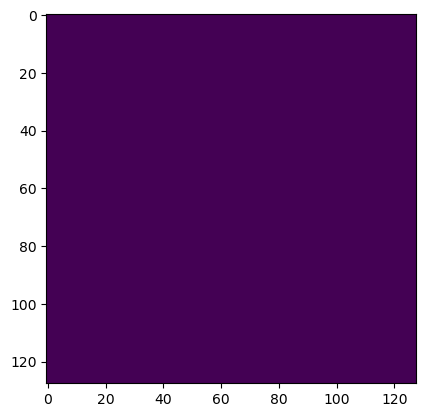

In [ ]:
plt.imshow(generated_images[0])

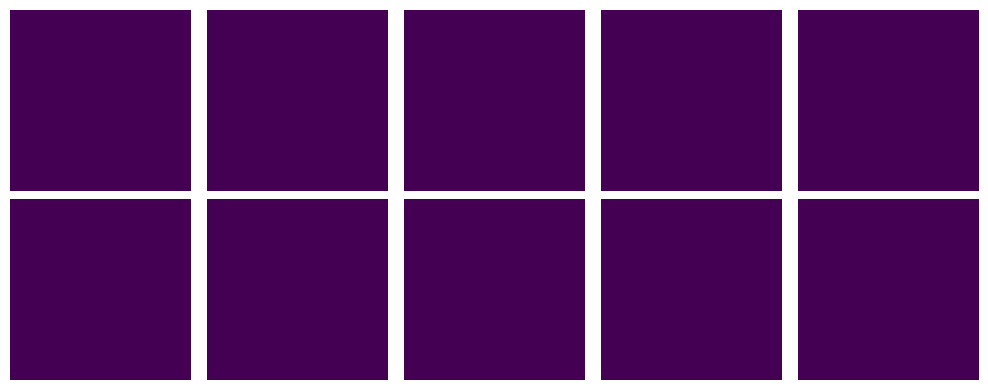

In [ ]:
import matplotlib.pyplot as plt

# Reshape the generated images to (num_images, 128, 128)
generated_images = generated_images.reshape((num_images, 128, 128))

# Create a figure and axes
fig, axes = plt.subplots(2, 5, figsize=(10, 4))

# Iterate over the axes and images
for i, ax in enumerate(axes.flat):
    # Plot the image
    ax.imshow(generated_images[i], cmap='viridis')
    ax.axis('off')

# Adjust the spacing between subplots
plt.tight_layout()

# Show the plot
plt.show()

## Fully Connected Variational Autoencoders (FCVAEs)

In [52]:
class VAEConnected(keras.Model):
    def __init__(self, encoder, decoder, **kwargs):
        super().__init__(**kwargs)
        self.encoder = encoder
        self.decoder = decoder
        self.total_loss_tracker = keras.metrics.Mean(name="total_loss")
        self.reconstruction_loss_tracker = keras.metrics.Mean(name="reconstruction_loss")
        self.kl_loss_tracker = keras.metrics.Mean(name="kl_loss")
        self.regularization_loss = keras.metrics.Mean(name="regularization_loss")

    @property
    def metrics(self):
        return [self.total_loss_tracker,
                self.reconstruction_loss_tracker,
                self.kl_loss_tracker,
                self.regularization_loss]
    
    def train_step(self, data):
        with tf.GradientTape() as tape:
            z_mean, z_log_var, z = self.encoder(data, training=True)
            reconstruction = self.decoder(z)
            reconstruction_loss = tf.reduce_mean(
                tf.reduce_sum(
                    keras.losses.binary_crossentropy(data, reconstruction), axis=(1,2)
                )
            )
            kl_loss = -0.5 * (1 + z_log_var - tf.square(z_mean) - tf.exp(z_log_var))
            kl_loss = tf.reduce_mean(tf.reduce_sum(kl_loss, axis=1))
            mean_loss = tf.reduce_mean(tf.square(z_mean))
            cov_loss = tf.reduce_mean(tf.exp(z_log_var)- z_log_var - 1)
            regularization_loss = mean_loss + cov_loss
            # total_loss = reconstruction_loss + kl_loss + regularization_loss
            total_loss = reconstruction_loss
        grads = tape.gradient(total_loss, self.trainable_weights)
        self.optimizer.apply_gradients(zip(grads, self.trainable_weights))
        self.total_loss_tracker.update_state(total_loss)
        self.reconstruction_loss_tracker.update_state(reconstruction_loss)
        self.kl_loss_tracker.update_state(kl_loss)
        self.regularization_loss.update_state(regularization_loss)
        return {"loss": self.total_loss_tracker.result(),
                "reconstruction_loss": self.reconstruction_loss_tracker.result(),
                "kl_loss": self.kl_loss_tracker.result(),
                "regularization_loss": self.regularization_loss.result()
            }        

In [53]:
# Encoder
latent_dim = 100

encoder_inputs = tf.keras.Input(shape=(128, 128, 1))
x = layers.Flatten()(encoder_inputs)
x = layers.Dense(256, activation="relu")(x)
x = layers.Dense(128, activation="relu")(x)
z_mean = layers.Dense(latent_dim, name="z_mean")(x)
z_log_var = layers.Dense(latent_dim, name="z_log_var")(x)
z = Sampling()([z_mean, z_log_var])

In [54]:
# Decoder
decoder_inputs = layers.Input(shape=(latent_dim,))
x = layers.Dense(128, activation="relu")(decoder_inputs)
x = layers.Dense(256, activation="relu")(x)
x = layers.Dense(128 * 128, activation="sigmoid")(x)
decoder_outputs = layers.Reshape((128, 128, 1))(x)

In [55]:
# Create the encoder model
encoder_connected = keras.Model(encoder_inputs, [z_mean, z_log_var, z], name="encoder")
encoder_connected.summary()

Model: "encoder"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_11 (InputLayer)          [(None, 128, 128, 1  0           []                               
                                )]                                                                
                                                                                                  
 flatten_4 (Flatten)            (None, 16384)        0           ['input_11[0][0]']               
                                                                                                  
 dense_14 (Dense)               (None, 256)          4194560     ['flatten_4[0][0]']              
                                                                                                  
 dense_15 (Dense)               (None, 128)          32896       ['dense_14[0][0]']         

In [56]:
# Create the decoder model
decoder_connected = keras.Model(decoder_inputs, decoder_outputs, name="decoder")
decoder_connected.summary()

Model: "decoder"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_12 (InputLayer)       [(None, 100)]             0         
                                                                 
 dense_16 (Dense)            (None, 128)               12928     
                                                                 
 dense_17 (Dense)            (None, 256)               33024     
                                                                 
 dense_18 (Dense)            (None, 16384)             4210688   
                                                                 
 reshape_5 (Reshape)         (None, 128, 128, 1)       0         
                                                                 
Total params: 4,256,640
Trainable params: 4,256,640
Non-trainable params: 0
_________________________________________________________________


### Model

In [36]:
# Define the VAE model
vae_connected = VAEConnected(encoder_connected, decoder_connected)

# Compile the VAE model
vae_connected.compile(optimizer=keras.optimizers.Adam())

### Training

In [37]:
# Train the VAE model
vae_connected.fit(x_train_reshaped, epochs=10, batch_size=32)

Epoch 1/10
1563/1563 [==============================] - 79s 50ms/step - loss: 196.0276 - reconstruction_loss: 196.3919 - kl_loss: 0.0092 - regularization_loss: 1.8322e-04
Epoch 2/10
1563/1563 [==============================] - 76s 49ms/step - loss: 196.2980 - reconstruction_loss: 196.3862 - kl_loss: 0.0679 - regularization_loss: 0.0014
Epoch 3/10
1563/1563 [==============================] - 70s 45ms/step - loss: 195.9529 - reconstruction_loss: 196.3786 - kl_loss: 0.0679 - regularization_loss: 0.0014
Epoch 4/10
1563/1563 [==============================] - 70s 45ms/step - loss: 196.4580 - reconstruction_loss: 196.3870 - kl_loss: 0.0679 - regularization_loss: 0.0014
Epoch 5/10
1563/1563 [==============================] - 68s 44ms/step - loss: 196.3212 - reconstruction_loss: 196.3886 - kl_loss: 0.0679 - regularization_loss: 0.0014
Epoch 6/10
1563/1563 [==============================] - 67s 43ms/step - loss: 196.5548 - reconstruction_loss: 196.3808 - kl_loss: 0.0713 - regularization_loss: 0

### Saving/loading models


In [57]:
# Save the VAE model
vae_connected.save_weights("models/vae_connected_dim100__weights", save_format="tf")

In [ ]:
# Uncomment to load a saved VAE model
# new_model = VAE(encoder, decoder)
# new_model.compile(optimizer=keras.optimizers.Adam())

# new_model.fit(x_train_reshaped[:5])
# new_model.load_weights("models/test_saving_vae")

1/1 [==============================] - 1s 1s/step - loss: 11282.7637 - reconstruction_loss: 11282.5391 - kl_loss: 0.1121 - regularization_loss: 0.0022


In [44]:
# Generating 0's images
np.sum(generated_images[0])

0.0

### Predicting new images

In [39]:
# Generate new images from random latent vectors
num_images = 10  # Number of images to generate
random_latent_vectors = tf.random.normal(shape=(num_images, latent_dim))
generated_images = vae_connected.decoder.predict(random_latent_vectors)

1/1 [==============================] - 0s 137ms/step


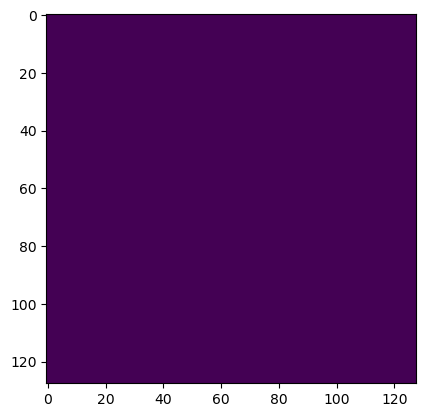

In [40]:
plt.imshow(generated_images[0])

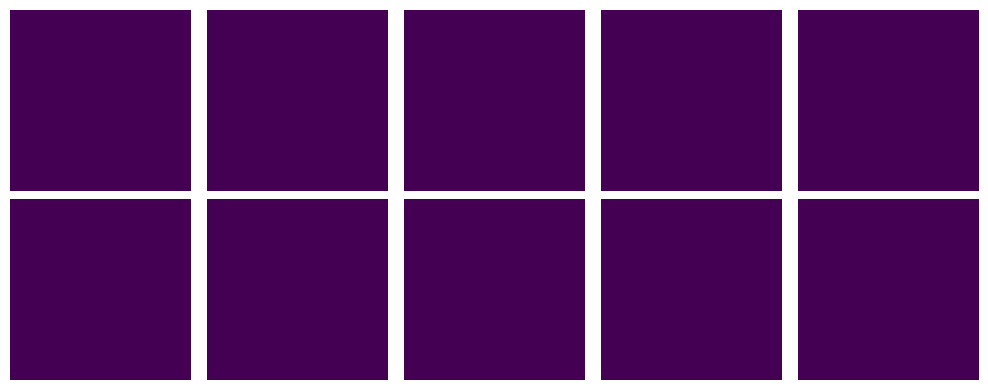

In [41]:
import matplotlib.pyplot as plt

# Reshape the generated images to (num_images, 128, 128)
generated_images = generated_images.reshape((num_images, 128, 128))

# Create a figure and axes
fig, axes = plt.subplots(2, 5, figsize=(10, 4))

# Iterate over the axes and images
for i, ax in enumerate(axes.flat):
    # Plot the image
    ax.imshow(generated_images[i], cmap='viridis')
    ax.axis('off')

# Adjust the spacing between subplots
plt.tight_layout()

# Show the plot
plt.show()

1/1 [==============================] - 0s 28ms/step


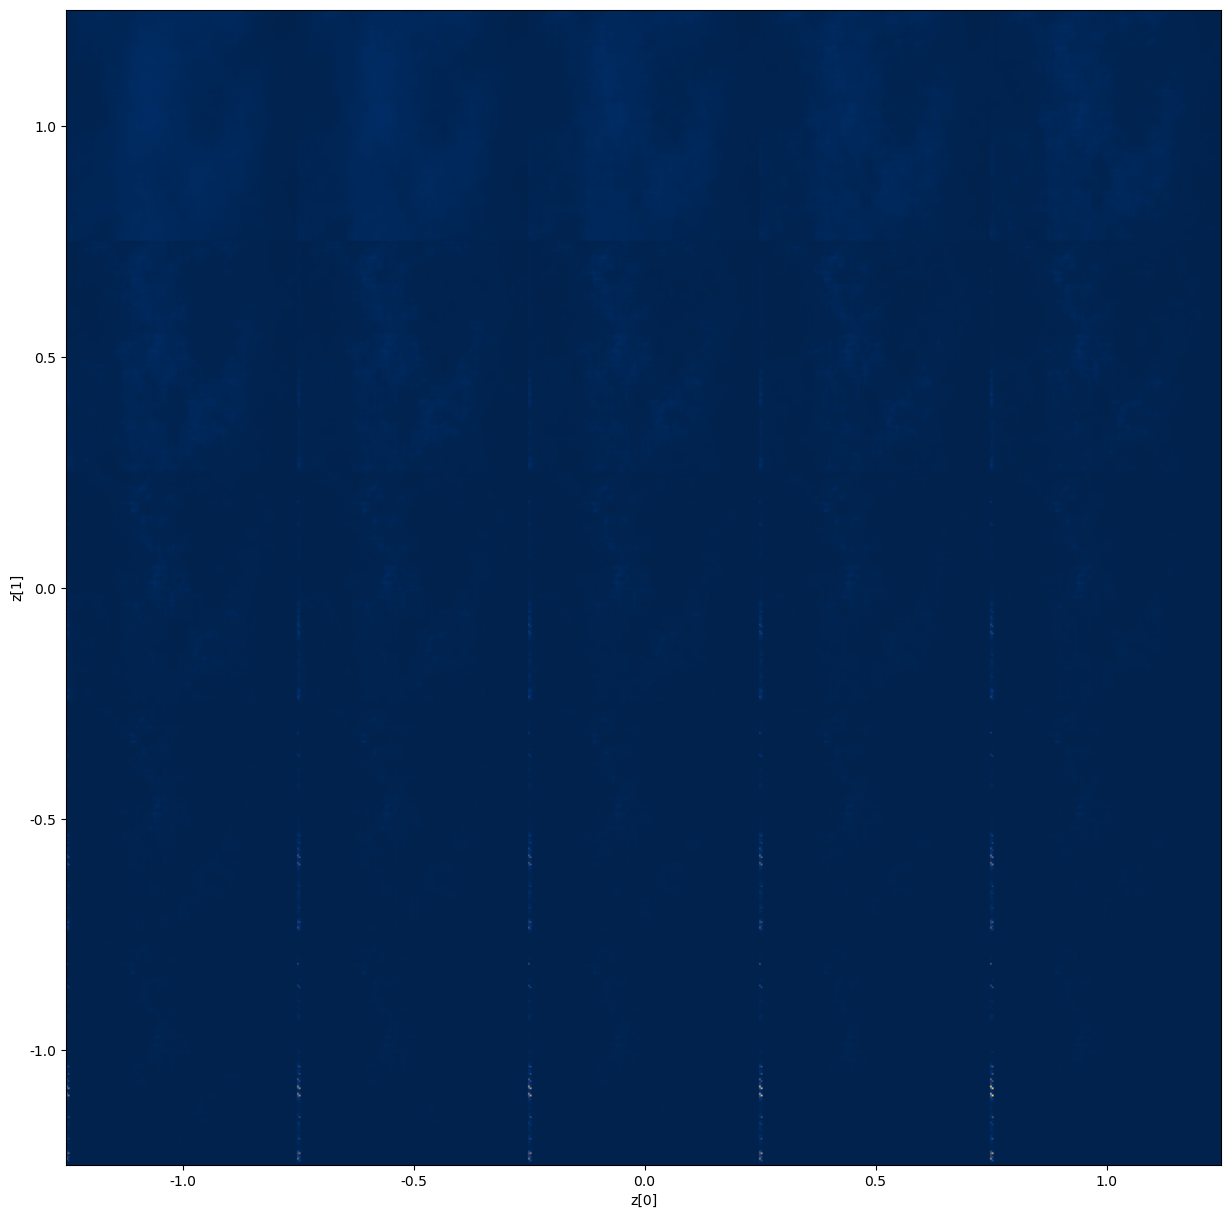

In [ ]:
def plot_latent_space(vae, n=5, figsize=15):
    # display a n*n 2D manifold of digits
    digit_size = 128
    scale = 1.0
    figure = np.zeros((digit_size * n, digit_size * n))
    # linearly spaced coordinates corresponding to the 2D plot
    # of digit classes in the latent space
    grid_x = np.linspace(-scale, scale, n)
    grid_y = np.linspace(-scale, scale, n)[::-1]
    # Initial latent vector
    initial_latent_vector = tf.random.normal(shape=(1, latent_dim))

    for i, yi in enumerate(grid_y):
        for j, xi in enumerate(grid_x):
            z_sample = initial_latent_vector + 0.5
            x_decoded = vae.decoder.predict(z_sample)
            digit = x_decoded[0].reshape(digit_size, digit_size)
            initial_latent_vector = z_sample
            figure[
                i * digit_size : (i + 1) * digit_size,
                j * digit_size : (j + 1) * digit_size,
            ] = digit

    plt.figure(figsize=(figsize, figsize))
    start_range = digit_size // 2
    end_range = n * digit_size + start_range
    pixel_range = np.arange(start_range, end_range, digit_size)
    sample_range_x = np.round(grid_x, 1)
    sample_range_y = np.round(grid_y, 1)
    plt.xticks(pixel_range, sample_range_x)
    plt.yticks(pixel_range, sample_range_y)
    plt.xlabel("z[0]")
    plt.ylabel("z[1]")
    plt.imshow(figure, cmap="cividis")
    plt.show()


plot_latent_space(vae)

In [ ]:
file.close()